# Tarea 2 MA-5701

Integrantes:

    - Sebastian Lopez
    - Kurt Walsen
    - Francisco Vásquez

# Previos

## Importación de Librerías

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as tick
import datetime as dt
import scipy.optimize as opti

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Parámetros Generales

In [2]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 50)

# Parámetros para gráficos
plt.style.use('seaborn')

plt.rcParams.update({'font.size': 25})      
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)  
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rcParams['axes.titlesize'] = 25
plt.rcParams["figure.figsize"] = (15,6)

# Trabajo de Datos

## Importación

In [3]:
df = pd.read_csv('data/data_modificada.csv')

## Trabajo previo

In [4]:
df.head()

,Fecha,Dia,Casos Totales,Recuperados,Fallecidos,Removidos
0,3/3/2020,1,1,0,0,0
1,3/4/2020,2,3,0,0,0
2,3/5/2020,3,4,0,0,0
3,3/6/2020,4,5,0,0,0
4,3/7/2020,5,7,0,0,0


In [5]:
df.Fecha = pd.to_datetime(df.Fecha)
df = df.sort_values(by = 'Fecha')

# Visualizaciones

In [52]:
def plot_columna(columna):
    data = df.set_index('Fecha')[columna]
    
    fig, ax = plt.subplots()
    
    grafico = data.plot(kind = 'line', ax = ax,
                       style = '.-', linewidth = 2,
                       ms = 10)
    
    if columna == 'Fallecidos':
        plt.gca().yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: str(int(x)) ))
    else:
        plt.gca().yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: str(int(x//1000)) + 'M' ))
    
    ax.set_ylabel('Cantidad de {}'.format(columna))
    ax.set_xlabel('Fecha')
    
    plt.title('Cantidad de {} por Fecha'.format(columna))
    plt.tight_layout()
    plt.savefig('graficos_informe/graf_cantidad_{}_fecha.pdf'.format(columna.replace(' ','')),
               format = 'pdf',
               dpi = 600)
    plt.show()

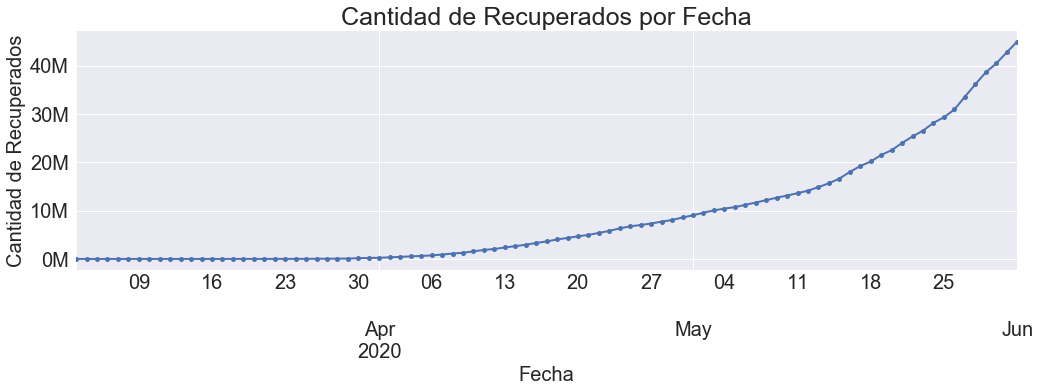

In [53]:
plot_columna('Recuperados')

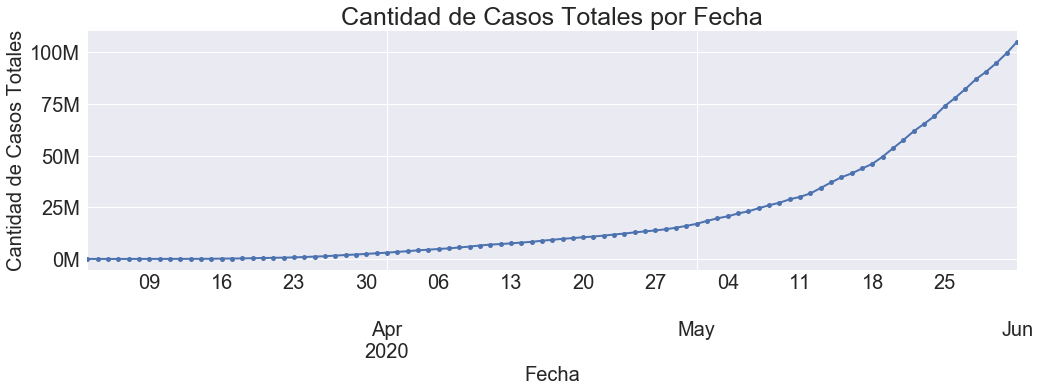

In [54]:
plot_columna('Casos Totales')

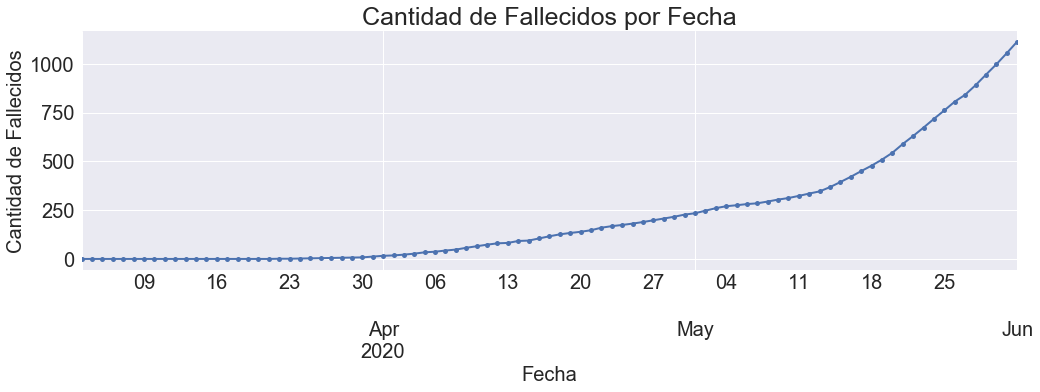

In [55]:
plot_columna('Fallecidos')

# Funciones Generadoras Ajustes

## Función de Ajuste

In [9]:
def func_de_ajuste(columna):
    '''
    Función que recibe una columna y retorna la función f(alpha, beta, sigma) 
    reemplazando con los valores respectivos de I(t) con la columna especificada
    '''
    def func_to_optimize_ajuste(params):
        '''
        Función a optimizar
        
        Recibe un vector de parámetros donde los parámetros de las posiciones 0,1,2 representan a 
        alpha, beta, sigma respectivamente
        
        Retorna la función f(alpha, beta, sigma)
        '''
        alpha = params[0]
        beta = params[1]
        sigma = params[2]

        val = 0
        for dia, n_infectados in enumerate(df[columna]):
            logit = (alpha)/(1 + beta * np.exp(-(dia + 1) / sigma))
            val += np.power(n_infectados - logit, 2)

        return val
    
    return func_to_optimize_ajuste

## Función de Máximo Error

In [10]:
def func_max_error(columna):
    '''
    Función que recibe una columna y retorna la función max(I(t) - %(t)), for all  t in T
    reemplazando con los valores respectivos de I(t) con la columna especificada
    '''
    def func_to_optimize_error(params):
        '''
        Función a optimizar
        
        Recibe un vector de parámetros donde los parámetros de las posiciones 0,1,2 representan a 
        alpha, beta, sigma respectivamente
        
        Retorna la función max(I(t) - %(t)), for all  t in T
        '''
        alpha = params[0]
        beta = params[1]
        sigma = params[2]

        val = []
        for dia, n_infectados in enumerate(df[columna]):
            logit = (alpha)/(1 + beta * np.exp(-(dia+ 1) / sigma))
            val.append(np.power(n_infectados - logit, 2))

        return np.max(val)
    
    return func_to_optimize_error

# Modelo Infectados

## Modelo General,  Función de Ajuste

In [11]:
# Función de ajuste con columna de Casos Totales
func_to_optimize_infectados_fa = func_de_ajuste('Casos Totales')

# LB y UB para cada uno de los parámetros
# En orden, son cotas para alpha, beta, sigma
bnds_infectados = ((0, None), (0, None), (0, None))

# Valores iniciales para alpha, beta, sigma
x0_infectados_general = [644444., 275., 24.5]

# Modelo infectados general con función de ajuste
mod_infectados_general_fa = opti.minimize(fun = func_to_optimize_infectados_fa,
                                       x0 = x0_infectados_general,
                                       bounds = bnds_infectados)

## Modelo  Máximo 250M, Función de Ajuste

In [12]:
# Se utiliza la misma función de ajuste con la columna de casos totales que para el caso general

# LB y UB para cada uno de los parámetros
# En orden, son cotas para alpha, beta, sigma
bnds_infectados_cota = ((0, 250000), (0, None), (0, None))

# Valores iniciales para alpha, beta, sigma
x0_infectados_cota = [250000., 300., 18.]

# Modelo infectados con cota sobre alpha con función de ajuste
mod_infectados_cota_fa = opti.minimize(fun = func_to_optimize_infectados_fa,
                                    x0 = x0_infectados_cota,
                                    bounds = bnds_infectados_cota)

## Modelo General, Máximo Error

In [13]:
# Función de máximo error con columna de Casos Totales
func_to_optimize_infectados_me = func_max_error('Casos Totales')

# LB y UB para cada uno de los parámetros
# En orden, son cotas para alpha, beta, sigma
bnds_infectados_me = ((0, None), (0, None), (0, None))

# Valores iniciales para alpha, beta, sigma
x0_infectados_general_me = [644444., 275., 24.5]

# Modelo infectados general con función de ajuste
mod_infectados_general_me = opti.minimize(fun = func_to_optimize_infectados_me,
                                          x0 = x0_infectados_general_me,
                                          bounds = bnds_infectados_me)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


## Modelo Máximo 250M, Máximo Error

In [14]:
# LB y UB para cada uno de los parámetros
# En orden, son cotas para alpha, beta, sigma
bnds_infectados_cota_me = ((0, 250000), (0, None), (0, None))

# Valores iniciales para alpha, beta, sigma
x0_infectados_cota_me = [1000000., 200., 10.]

# Modelo infectados general con función de ajuste
mod_infectados_cota_me = opti.minimize(fun = func_to_optimize_infectados_me,
                                       x0 = x0_infectados_cota_me,
                                       bounds = bnds_infectados_cota_me)

## Guardado de modelos

In [15]:
modelos_infectados = {'Cota': {'FA': mod_infectados_cota_fa ,
                              'ME': mod_infectados_cota_me},
                     'General':{'FA': mod_infectados_general_fa,
                               'ME': mod_infectados_general_me}}

# Modelo Fallecidos

## Modelo Fallecidos General, Función de Ajuste

In [16]:
# Función de ajuste con columna de Fallecidos
func_to_optimize_fallecidos_fa = func_de_ajuste('Fallecidos')

# LB y UB para cada uno de los parámetros
# En orden, son cotas para alpha, beta, sigma
bnds_fallecidos_fa = ((0, 18000000), (0, None), (0, None))

# Valores iniciales para alpha, beta, sigma
x0_fallecidos_general_fa = [12277.8, 155., 19.]

# Modelo Fallecidos General con Función de ajuste
mod_fallecidos_general_fa = opti.minimize(fun = func_to_optimize_fallecidos_fa,
                                       x0 = x0_fallecidos_general_fa,
                                       bounds = bnds_fallecidos_fa)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


## Modelo Fallecidos máximo 250M, Función de Ajuste

In [17]:
# LB y UB para cada uno de los parámetros
# En orden, son cotas para alpha, beta, sigma
bnds_fallecidos_cota_fa = ((0, 5000), (0, None), (0, None))

# Valores iniciales para alpha, beta, sigma
x0_fallecidos_cota_fa = [500.0,200.0,30.0]

# Modelo Fallecidos General con Función de ajuste
mod_fallecidos_cota_fa = opti.minimize(fun = func_to_optimize_fallecidos_fa, # Se utiliza la misma funcion
                                       x0 = x0_fallecidos_cota_fa,
                                       bounds = bnds_fallecidos_cota_fa)

## Modelo Fallecidos General, Máximo Error

In [18]:
# Función de máximo error con columna de Fallecidos
func_to_optimize_fallecidos_me = func_max_error('Fallecidos')

# LB y UB para cada uno de los parámetros
# En orden, son cotas para alpha, beta, sigma
bnds_fallecidos_me = ((0, 18000000), (0, None), (0, None))

# Valores iniciales para alpha, beta, sigma
x0_fallecidos_general_me = [1500.0,200.0,30.0]

# Modelo Fallecidos General con Función de ajuste
mod_fallecidos_general_me = opti.minimize(fun = func_to_optimize_fallecidos_me,
                                       x0 = x0_fallecidos_general_me,
                                       bounds = bnds_fallecidos_me)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


## Modelo Fallecidos máximo 250M, Máximo Error

In [19]:
# LB y UB para cada uno de los parámetros
# En orden, son cotas para alpha, beta, sigma
bnds_fallecidos_cota_me = ((0, 5000), (0, None), (0, None))

# Valores iniciales para alpha, beta, sigma
x0_fallecidos_cota_me = [1500.0,155.0,30.0]

# Modelo Fallecidos General con Función de ajuste
mod_fallecidos_cota_me = opti.minimize(fun = func_to_optimize_fallecidos_me, # Se utiliza la misma funcion
                                       x0 = x0_fallecidos_cota_me,
                                       bounds = bnds_fallecidos_cota_me)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


## Guardado de modelos

In [20]:
modelos_fallecidos = {'Cota': {'FA': mod_fallecidos_cota_fa ,
                              'ME': mod_fallecidos_cota_me},
                     'General':{'FA': mod_fallecidos_general_fa,
                               'ME': mod_fallecidos_general_me}}

# Auxiliares predicciones

In [21]:
def predicciones(params, vec_dias):
    '''
    Función que recibe vector de parámetros para alpha, beta, sigma y un vector de días cualquiera
    y retorna una lista con la función I(t, alpha, beta, sigma) evaluada en cada uno de los puntos de la lista 
    de días
    '''
    alpha = params[0]
    beta = params[1]
    sigma = params[2]
    
    fun = lambda t: (alpha)/(1 + beta * np.exp(-t / sigma))
    
    return list(map(fun, vec_dias))

In [70]:
def plot_juntos(columna, params, dias,titulogeneral):
        
    dia = df['Dia']
    original = df[columna]
    
    pred_ajuste = predicciones(params, dia)
    pred_futuro= predicciones(params, range(92,dias+1)) 
    
    dia_cota = np.argmax(pred_futuro > params[0]*0.95)
    valor_cota = list(range(92,dias+1))[dia_cota]
    
    fecha_cota = f'{dt.datetime(2020,3,3) + dt.timedelta(days = valor_cota-1):%d-%m-%Y}'
    
    print('Fecha Cota: {}'.format(fecha_cota))
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.subplots_adjust(top=0.8)
    fig.suptitle(titulogeneral, y = 0.995)
    
    ax1.scatter(dia, original, alpha = 0.8, s = 15, label = '{} Real'.format(columna),
                              c = 'green')
    ax1.plot(dia, pred_ajuste, label = 'Ajuste', c = 'royalblue')
    
    ax2.scatter(dia, original, alpha = 0.8, s = 10, label = '{} Real'.format(columna),
                              c = 'green')
    ax2.plot(range(92,dias+1), pred_futuro, label = 'Predicciones Futuro')
    
    
    ax2.axvline( x = valor_cota, c = 'm', label = 'Día {}'.format(valor_cota) , linestyle = '--')
    
    if columna == 'Fallecidos':
        ax1.yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: str(int(x)) ))
        ax2.yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: str(int(x)) ))
    else:
        ax1.yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: str(int(x//1000)) + 'M' ))
        ax2.yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: str(int(x//1000)) + 'M' ))
    
    ax1.set_xlabel('Día')
    ax1.set_ylabel('Cantidad de {}'.format(columna))
    ax2.set_xlabel('Día')
    
    ax1.set_title('Ajuste', size = 20)
    ax2.set_title('Predicción', size = 20)  
    
    ax1.legend(loc = 2,prop={'size': 15})
    ax2.legend(loc = 2,prop={'size': 15})
    
    plt.tight_layout()  
    plt.savefig('graficos_informe/' + titulogeneral + '.pdf', dpi = 600, format = 'pdf' )
    plt.show()

In [71]:
def print_parametros(modelo):
    print('Parámetros encontrados:\n Alpha: {} \n Beta: {} \n Sigma: {}'.format(round(modelo.x[0], 2),
                                                                            round(modelo.x[1], 2),
                                                                            round(modelo.x[2], 2)))

# Predicciones Infectados 

## General, Función de Ajuste

Parámetros encontrados:
 Alpha: 621140.88 
 Beta: 1552.85 
 Sigma: 15.79

 El RMSE obtenido con las predicciones es de
 RMSE: 1124.99

 El Score R2 obtenidos con las predicciones es de
 R2: 0.9983
Fecha Cota: 12-08-2020


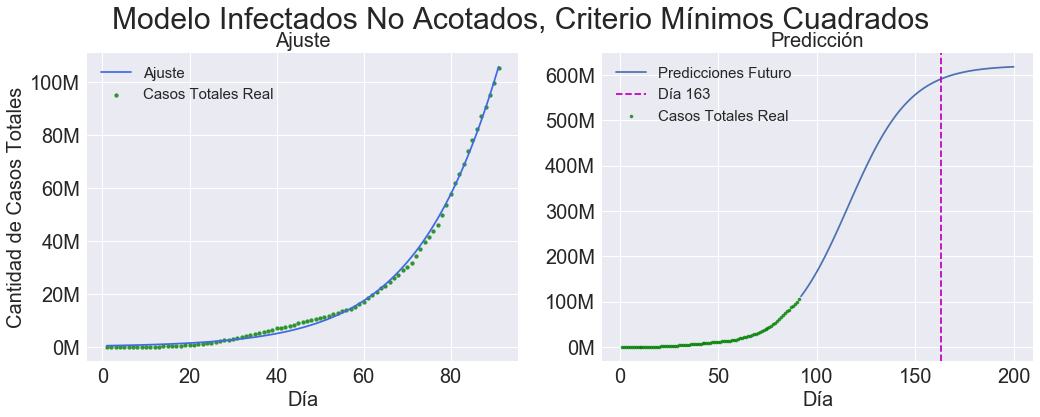

In [72]:
print_parametros(modelos_infectados['General']['FA'])

# Prediccion con los parámetros obtenidos de mod_infectados
pred_general_fa = predicciones(modelos_infectados['General']['FA'].x, df['Dia'])

# Raíz cuadrada del error cuadrático medio
rmse_infectados_general_fa = np.sqrt(mean_squared_error(df['Casos Totales'], pred_general_fa))
r2_infectados_general_fa = r2_score(df['Casos Totales'], pred_general_fa)

print('\n El RMSE obtenido con las predicciones es de\n RMSE: {}'.format(round(rmse_infectados_general_fa,2)))
print('\n El Score R2 obtenidos con las predicciones es de\n R2: {}'.format(round(r2_infectados_general_fa,4)))

plot_juntos('Casos Totales', 
            modelos_infectados['General']['FA'].x, 200,
            'Modelo Infectados No Acotados, Criterio Mínimos Cuadrados')

## Cota, Función de Ajuste

Parámetros encontrados:
 Alpha: 250000.0 
 Beta: 1109.12 
 Sigma: 13.71

 El RMSE obtenido con las predicciones es de
 RMSE: 1679.61

 El Score R2 obtenidos con las predicciones es de
 R2: 0.9961
Fecha Cota: 17-07-2020


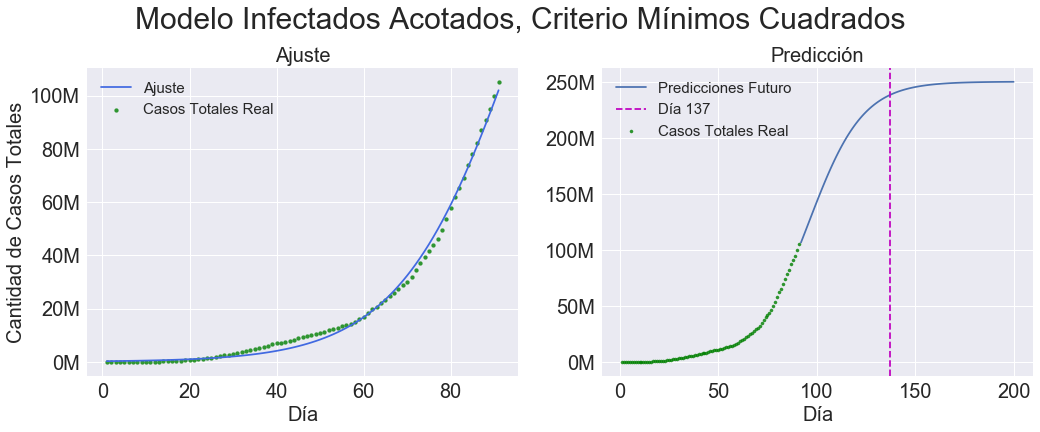

In [25]:
print_parametros(modelos_infectados['Cota']['FA'])

# Prediccion con los parámetros obtenidos de mod_infectados
pred_cota_fa = predicciones(modelos_infectados['Cota']['FA'].x, df['Dia'])

rmse_infectados_cota_fa = np.sqrt(mean_squared_error(df['Casos Totales'], pred_cota_fa))
r2_infectados_cota_fa = r2_score(df['Casos Totales'], pred_cota_fa)

print('\n El RMSE obtenido con las predicciones es de\n RMSE: {}'.format(round(rmse_infectados_cota_fa, 2)))
print('\n El Score R2 obtenidos con las predicciones es de\n R2: {}'.format(round(r2_infectados_cota_fa,4)))

plot_juntos('Casos Totales', 
            modelos_infectados['Cota']['FA'].x, 200,
            'Modelo Infectados Acotados, Criterio Mínimos Cuadrados')

## General, Máx Error

Parámetros encontrados:
 Alpha: 639546.58 
 Beta: 471.04 
 Sigma: 20.55

 El RMSE obtenido con las predicciones es de
 RMSE: 4642.3

 El Score R2 obtenidos con las predicciones es de
 R2: 0.9705
Fecha Cota: 05-09-2020


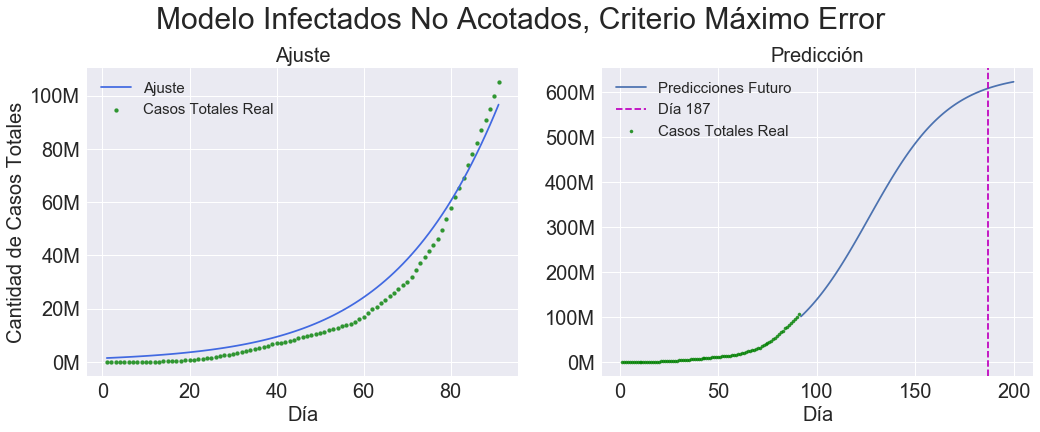

In [26]:
print_parametros(modelos_infectados['General']['ME'])

pred_general_me = predicciones(modelos_infectados['General']['ME'].x, df['Dia'])

rmse_infectados_general_me = np.sqrt(mean_squared_error(df['Casos Totales'], pred_general_me))
r2_infectados_general_me = r2_score(df['Casos Totales'], pred_general_me)


print('\n El RMSE obtenido con las predicciones es de\n RMSE: {}'.format(round(rmse_infectados_general_me, 2)))
print('\n El Score R2 obtenidos con las predicciones es de\n R2: {}'.format(round(r2_infectados_general_me,4)))


plot_juntos('Casos Totales', 
            modelos_infectados['General']['ME'].x, 200,
            'Modelo Infectados No Acotados, Criterio Máximo Error')

## Cota, Máx Error

Parámetros encontrados:
 Alpha: 250000.0 
 Beta: 200.11 
 Sigma: 19.01

 El RMSE obtenido con las predicciones es de
 RMSE: 6001.06

 El Score R2 obtenidos con las predicciones es de
 R2: 0.9507
Fecha Cota: 06-08-2020


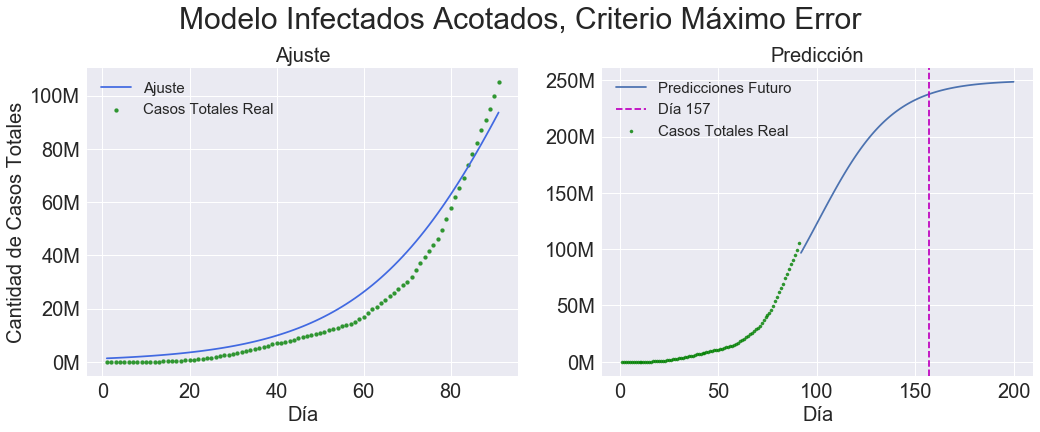

In [27]:
print_parametros(modelos_infectados['Cota']['ME'])

# Prediccion con los parámetros obtenidos de mod_infectados
pred_cota_me = predicciones(modelos_infectados['Cota']['ME'].x, df['Dia'])

rmse_infectados_cota_me = np.sqrt(mean_squared_error(df['Casos Totales'], pred_cota_me))
r2_infectados_cota_me = r2_score(df['Casos Totales'], pred_cota_me)

print('\n El RMSE obtenido con las predicciones es de\n RMSE: {}'.format(round(rmse_infectados_cota_me, 2)))
print('\n El Score R2 obtenidos con las predicciones es de\n R2: {}'.format(round(r2_infectados_cota_me,4)))


plot_juntos('Casos Totales', 
            modelos_infectados['Cota']['ME'].x, 200,
            'Modelo Infectados Acotados, Criterio Máximo Error')

# Predicciones Fallecidos

## General, Función de Ajuste

Parámetros encontrados:
 Alpha: 12256.72 
 Beta: 1816.18 
 Sigma: 17.58

 El RMSE obtenido con las predicciones es de
 RMSE: 23.78

 El Score R2 obtenidos con las predicciones es de
 R2: 0.9929
Fecha Cota: 02-09-2020


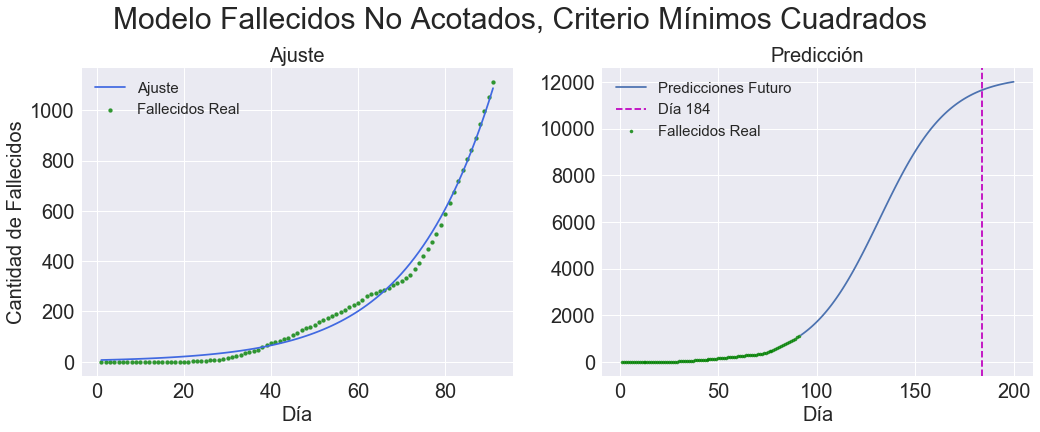

In [28]:
print_parametros(modelos_fallecidos['General']['FA'])

# Prediccion con los parámetros obtenidos de mod_infectados
pred_fallecidos_fa = predicciones(modelos_fallecidos['General']['FA'].x, df['Dia'])

rmse_fallecidos_fa = np.sqrt(mean_squared_error(df['Fallecidos'], pred_fallecidos_fa))
r2_fallecidos_fa = r2_score(df['Fallecidos'], pred_fallecidos_fa)

print('\n El RMSE obtenido con las predicciones es de\n RMSE: {}'.format(round(rmse_fallecidos_fa, 2)))
print('\n El Score R2 obtenidos con las predicciones es de\n R2: {}'.format(round(r2_fallecidos_fa,4)))

plot_juntos('Fallecidos', 
            modelos_fallecidos['General']['FA'].x, 200,
            'Modelo Fallecidos No Acotados, Criterio Mínimos Cuadrados')

## Cota, Función de Ajuste

Parámetros encontrados:
 Alpha: 5000.0 
 Beta: 904.37 
 Sigma: 16.53

 El RMSE obtenido con las predicciones es de
 RMSE: 25.71

 El Score R2 obtenidos con las predicciones es de
 R2: 0.9916
Fecha Cota: 11-08-2020


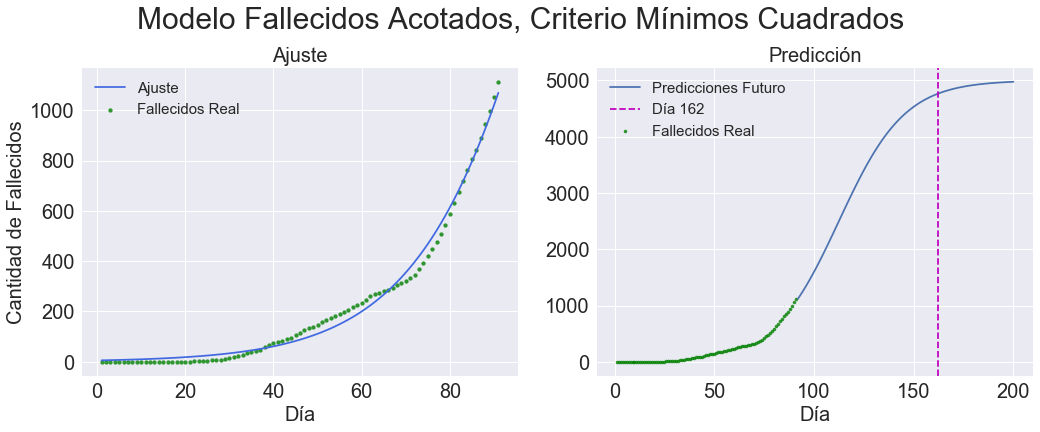

In [29]:
print_parametros(modelos_fallecidos['Cota']['FA'])

# Prediccion con los parámetros obtenidos de mod_infectados
pred_fallecidos_cota_fa = predicciones(modelos_fallecidos['Cota']['FA'].x, df['Dia'])

rmse_fallecidos_cota_fa = np.sqrt(mean_squared_error(df['Fallecidos'], pred_fallecidos_cota_fa))
r2_fallecidos_cota_fa = r2_score(df['Fallecidos'], pred_fallecidos_cota_fa)

print('\n El RMSE obtenido con las predicciones es de\n RMSE: {}'.format(round(rmse_fallecidos_cota_fa, 2)))
print('\n El Score R2 obtenidos con las predicciones es de\n R2: {}'.format(round(r2_fallecidos_cota_fa,4)))

plot_juntos('Fallecidos', 
            modelos_fallecidos['Cota']['FA'].x, 200,
            'Modelo Fallecidos Acotados, Criterio Mínimos Cuadrados')

## General, Máx Error

Parámetros encontrados:
 Alpha: 11562.28 
 Beta: 1739.71 
 Sigma: 17.57

 El RMSE obtenido con las predicciones es de
 RMSE: 24.34

 El Score R2 obtenidos con las predicciones es de
 R2: 0.9925
Fecha Cota: 01-09-2020


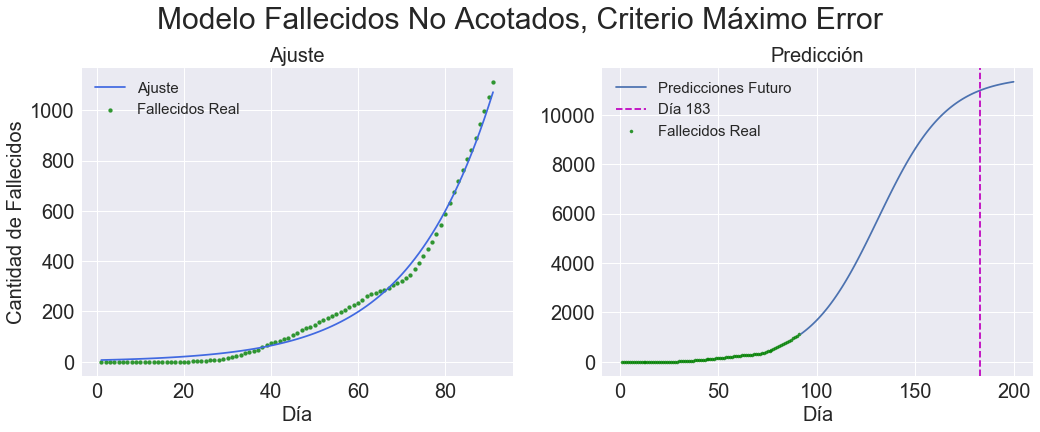

In [30]:
print_parametros(modelos_fallecidos['General']['ME'])

# Prediccion con los parámetros obtenidos de mod_infectados
pred_fallecidos_me = predicciones(modelos_fallecidos['General']['ME'].x, df['Dia'])

rmse_fallecidos_me = np.sqrt(mean_squared_error(df['Fallecidos'], pred_fallecidos_me))
r2_fallecidos_me = r2_score(df['Fallecidos'], pred_fallecidos_me)

print('\n El RMSE obtenido con las predicciones es de\n RMSE: {}'.format(round(rmse_fallecidos_me, 2)))
print('\n El Score R2 obtenidos con las predicciones es de\n R2: {}'.format(round(r2_fallecidos_me,4)))

plot_juntos('Fallecidos', 
            modelos_fallecidos['General']['ME'].x, 200,
            'Modelo Fallecidos No Acotados, Criterio Máximo Error')

## Cota, Máx Error

Parámetros encontrados:
 Alpha: 4178.27 
 Beta: 553.65 
 Sigma: 17.46

 El RMSE obtenido con las predicciones es de
 RMSE: 30.01

 El Score R2 obtenidos con las predicciones es de
 R2: 0.9886
Fecha Cota: 11-08-2020


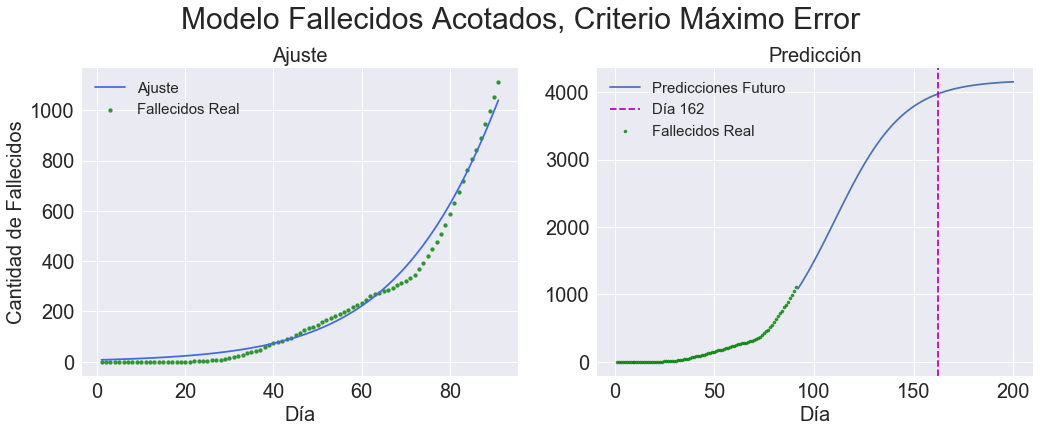

In [31]:
print_parametros(modelos_fallecidos['Cota']['ME'])

# Prediccion con los parámetros obtenidos de mod_infectados
pred_fallecidos_cota_me = predicciones(modelos_fallecidos['Cota']['ME'].x, df['Dia'])

rmse_fallecidos_cota_me = np.sqrt(mean_squared_error(df['Fallecidos'], pred_fallecidos_cota_me))
r2_fallecidos_cota_me = r2_score(df['Fallecidos'], pred_fallecidos_cota_me)

print('\n El RMSE obtenido con las predicciones es de\n RMSE: {}'.format(round(rmse_fallecidos_cota_me, 2)))
print('\n El Score R2 obtenidos con las predicciones es de\n R2: {}'.format(round(r2_fallecidos_cota_me,4)))

plot_juntos('Fallecidos', 
            modelos_fallecidos['Cota']['ME'].x, 200,
            'Modelo Fallecidos Acotados, Criterio Máximo Error')

# Comparaciones

In [32]:
dict_modelos = {'Casos Totales': modelos_infectados,
          'Fallecidos': modelos_fallecidos,}

In [73]:
def plot_modelos(columna, dias, titulo):
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 2]})
    fig.subplots_adjust(top=0.8)
    
    dia = df['Dia']
    original = df[columna]
    
    ax1.scatter(dia, original, alpha = 0.8, s = 15, label = '{} Real'.format(columna),
                                      c = 'green')
    ax2.scatter(dia, original, alpha = 0.8, s = 15, label = '{} Real'.format(columna),
                                      c = 'green')   
    
    modelos = dict_modelos[columna]
    
    rango = range(1, dias + 1)
    
    for mod in modelos.keys():
        for funcion in modelos[mod].keys():
            pred_ajuste = predicciones(modelos[mod][funcion].x, dia)
            pred_futuro = predicciones(modelos[mod][funcion].x, rango)
            
            ax1.plot(dia, pred_ajuste, label = 'Pred. {}, {}'.format(mod, funcion))
            ax2.plot(rango, pred_futuro, label = 'Pred. {}, {}'.format(mod, funcion))

    if columna == 'Fallecidos':
        ax1.yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: str(int(x)) ))
        ax2.yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: str(int(x)) ))
    else:
        ax1.yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: str(int(x//1000)) + 'M' ))
        ax2.yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: str(int(x//1000)) + 'M' ))


    ax1.set_ylabel('Cantidad de {}'.format(columna))
    ax2.set_xlabel('Día')
    ax1.set_xlabel('Día')

    ax1.set_title('Ajuste', size = 20)
    ax2.set_title('Predicción', size = 20)
    
    plt.suptitle(titulo, y=0.995)
    
    ax1.legend(loc = 2,prop={'size': 15})
    ax2.legend(loc = 2,prop={'size': 15})
    plt.tight_layout()
    plt.savefig('graficos_informe/{}.pdf'.format(titulo), format = 'pdf', dpi = 600)

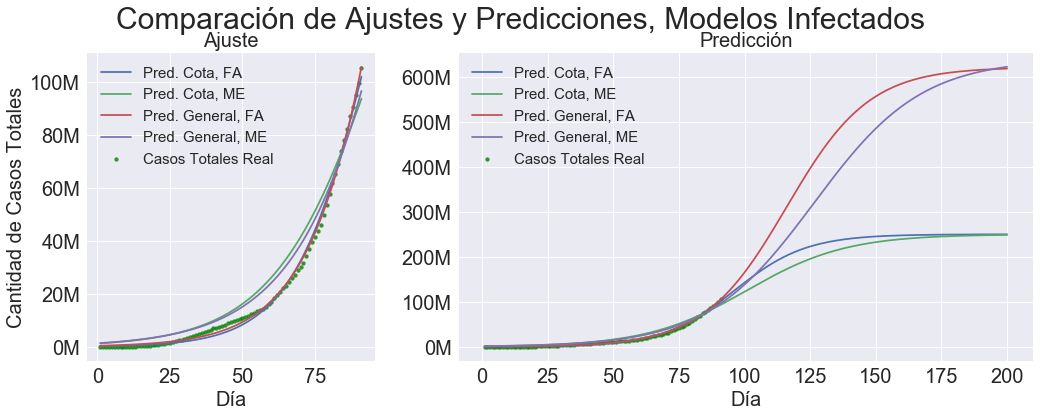

In [74]:
plot_modelos('Casos Totales', 200,
            'Comparación de Ajustes y Predicciones, Modelos Infectados')

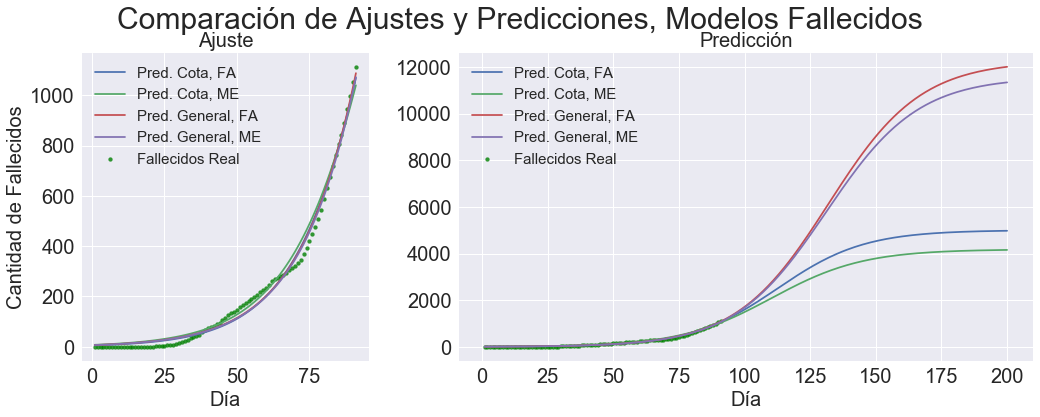

In [75]:
plot_modelos('Fallecidos', 200,
            'Comparación de Ajustes y Predicciones, Modelos Fallecidos')

# Día con más - nuevos

In [36]:
def plot_dia_maximo_nuevos(columna, params, dias, titulo):
    dias_posteriores = range(1,dias)
    pred_post_fa = predicciones(params, dias_posteriores)

    pred_infectados_dia = []

    for k in range(0, len(pred_post_fa)-1):
        if k == 0:
            i = pred_post_fa[0]
            j = pred_post_fa[1]
            c = j-i
            val = k
            pred_infectados_dia.append(c)
        else:
            i = pred_post_fa[k]
            j = pred_post_fa[k+1]
            if j-i > c:
                c = j-i
                val = k
            pred_infectados_dia.append(j-i)

    infectados_dia = []

    for k in range(0, len(df[columna])-1):
        infectados_dia.append(df[columna][k+1] - df[columna][k])

    dia_fecha = f'{dt.datetime(2020,3,3) + dt.timedelta(days=val):%d-%m-%Y}'
        
    print('El día con más infectados será el día {} '.format(val))
    print('Con fecha: {}'.format(dia_fecha))
    print('En donde habrán {} infectados nuevos'.format(int(pred_post_fa[val] - pred_post_fa[val-1])))

    fig, ax = plt.subplots()

    plt.plot(range(2, 92), infectados_dia, label = 'Casos por Día')
    plt.plot(range(1, dias-1), pred_infectados_dia, label = 'Pred. Casos por Día')

    ax.annotate('Máx. {}'.format(int(pred_infectados_dia[val])), xy=(val + 10, pred_infectados_dia[val]))

    plt.title(titulo + '\nPredicción de Casos por Día')
    ax.set_ylabel('Nuevos Casos por Día')
    ax.set_xlabel('Día de la Enfermedad')

    ax.axvline( x = val, c = 'm', label = 'Día {}'.format(val) , linestyle = '--')
    
    max_y = pred_post_fa[val] - pred_post_fa[val-1]
    
    if max(infectados_dia) > max_y:
        plt.ylim(0,max(infectados_dia)*1.15)
    else:
        plt.ylim(0,max_y*1.2)

    

    plt.legend()
    plt.tight_layout()

    plt.savefig('graficos_informe/{}.pdf'.format(titulo),
               format = 'pdf',
               dpi = 600)
    plt.show()

## Infectados

El día con más infectados será el día 115 
Con fecha: 26-06-2020
En donde habrán 9831 infectados nuevos


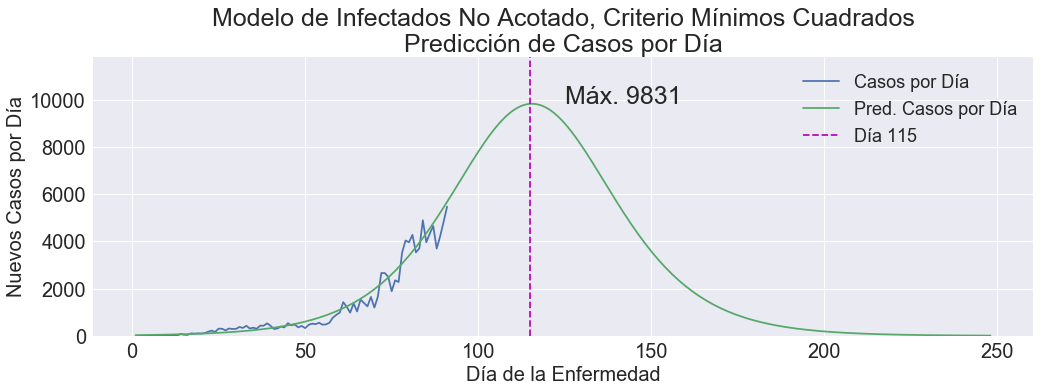

In [37]:
plot_dia_maximo_nuevos('Casos Totales', modelos_infectados['General']['FA'].x, 250,
                      'Modelo de Infectados No Acotado, Criterio Mínimos Cuadrados')

El día con más infectados será el día 95 
Con fecha: 06-06-2020
En donde habrán 4556 infectados nuevos


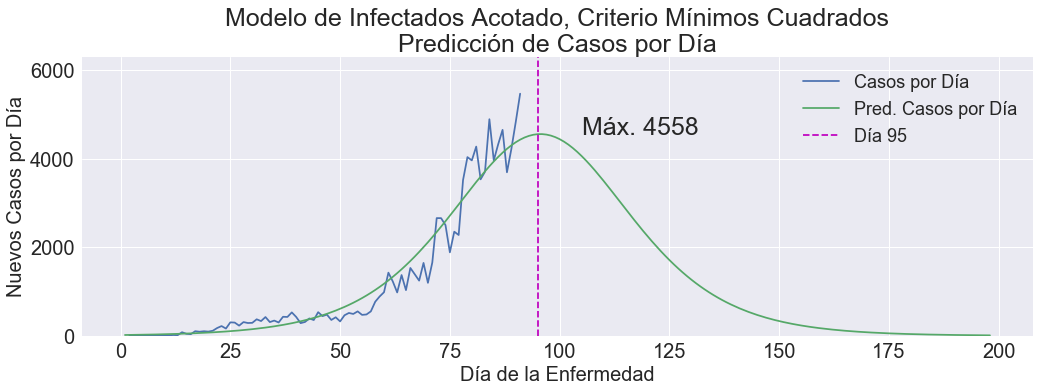

In [38]:
plot_dia_maximo_nuevos('Casos Totales', modelos_infectados['Cota']['FA'].x, 200,
                      'Modelo de Infectados Acotado, Criterio Mínimos Cuadrados')

El día con más infectados será el día 125 
Con fecha: 06-07-2020
En donde habrán 7776 infectados nuevos


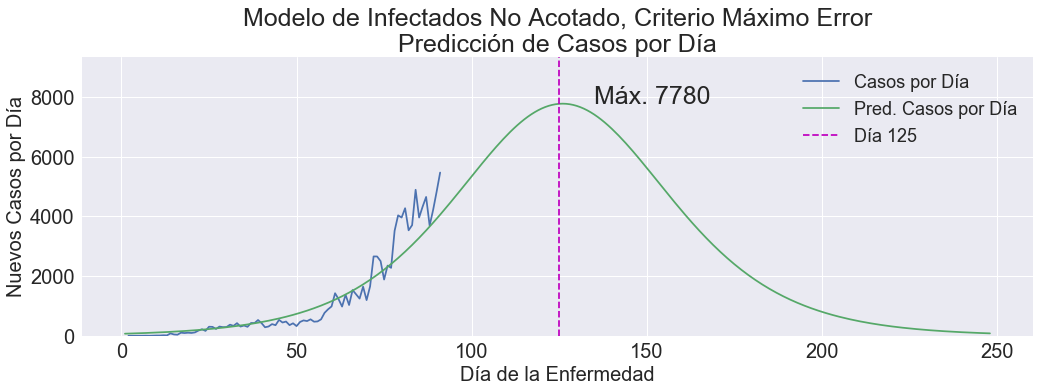

In [39]:
plot_dia_maximo_nuevos('Casos Totales', modelos_infectados['General']['ME'].x, 250,
                      'Modelo de Infectados No Acotado, Criterio Máximo Error')

El día con más infectados será el día 99 
Con fecha: 10-06-2020
En donde habrán 3283 infectados nuevos


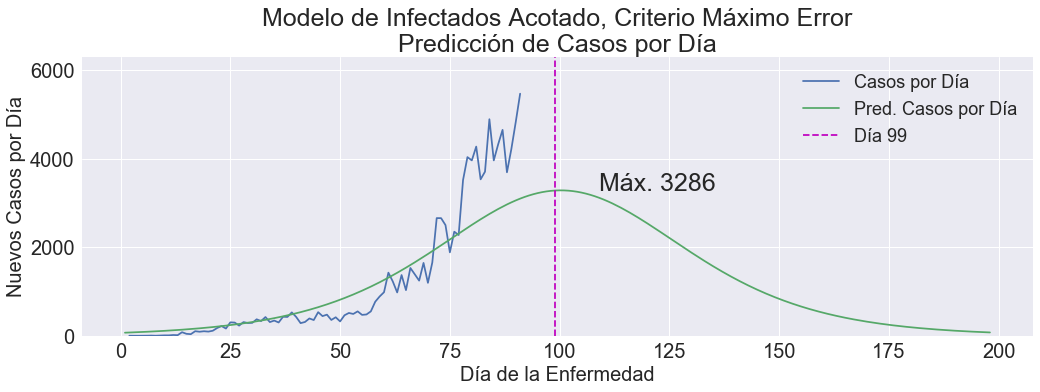

In [40]:
plot_dia_maximo_nuevos('Casos Totales', modelos_infectados['Cota']['ME'].x, 200,
                      'Modelo de Infectados Acotado, Criterio Máximo Error')

## Fallecidos

El día con más infectados será el día 130 
Con fecha: 11-07-2020
En donde habrán 173 infectados nuevos


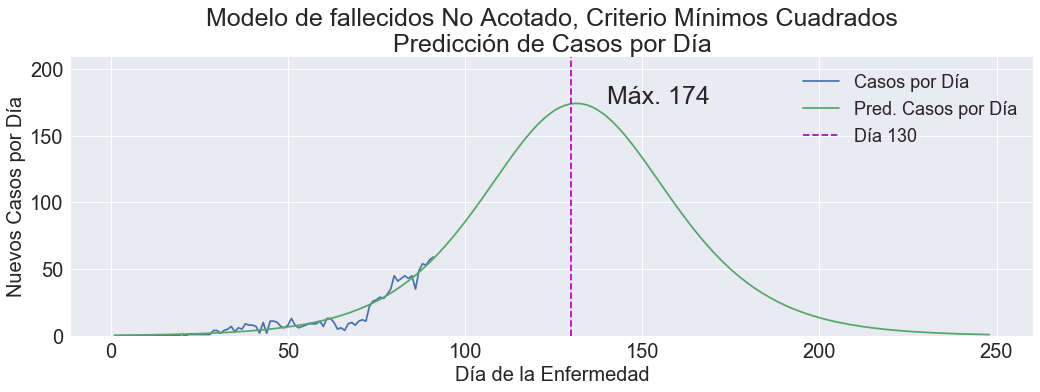

In [41]:
plot_dia_maximo_nuevos('Fallecidos', modelos_fallecidos['General']['FA'].x, 250,
                      'Modelo de fallecidos No Acotado, Criterio Mínimos Cuadrados')

El día con más infectados será el día 111 
Con fecha: 22-06-2020
En donde habrán 75 infectados nuevos


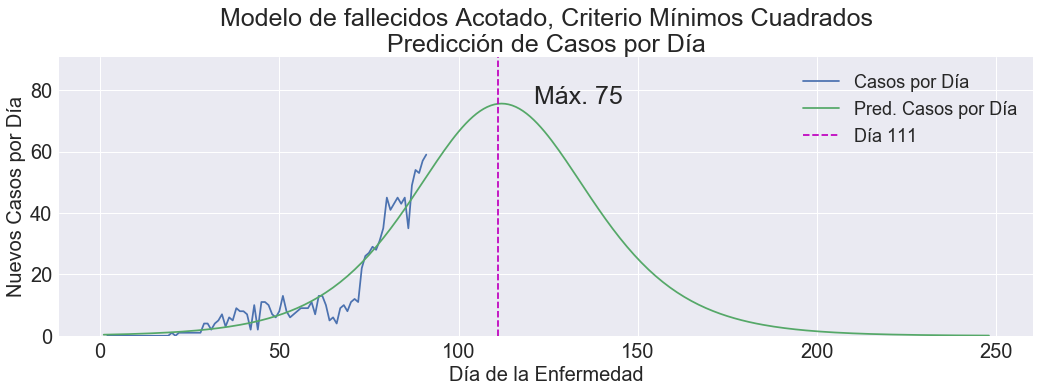

In [42]:
plot_dia_maximo_nuevos('Fallecidos', modelos_fallecidos['Cota']['FA'].x, 250,
                      'Modelo de fallecidos Acotado, Criterio Mínimos Cuadrados')

El día con más infectados será el día 130 
Con fecha: 11-07-2020
En donde habrán 164 infectados nuevos


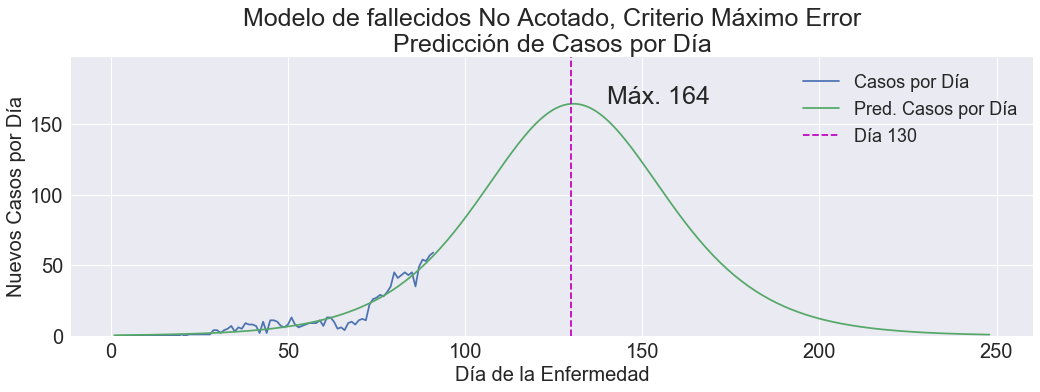

In [43]:
plot_dia_maximo_nuevos('Fallecidos', modelos_fallecidos['General']['ME'].x, 250,
                      'Modelo de fallecidos No Acotado, Criterio Máximo Error')

El día con más infectados será el día 109 
Con fecha: 20-06-2020
En donde habrán 59 infectados nuevos


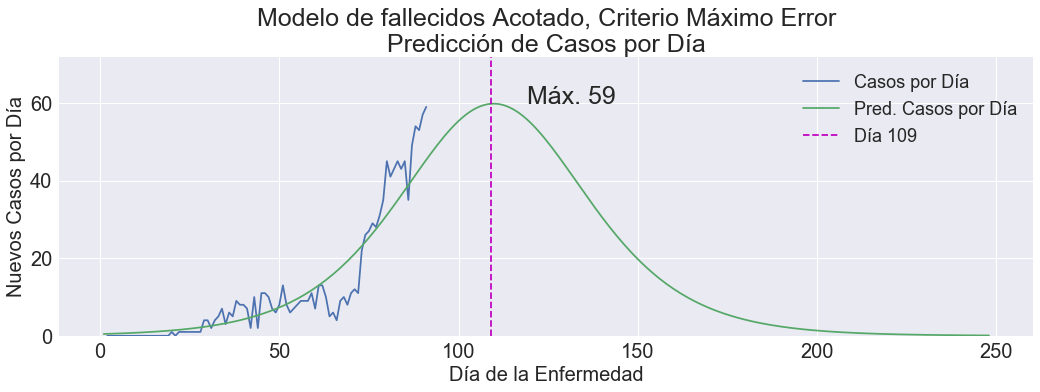

In [44]:
plot_dia_maximo_nuevos('Fallecidos', modelos_fallecidos['Cota']['ME'].x, 250,
                      'Modelo de fallecidos Acotado, Criterio Máximo Error')

# Búsqueda de Optimos

## Fallecidos ME

In [45]:
# # # Función de ajuste con columna de Casos Totales
# func_to_optimize_fallecidos = func_max_error('Fallecidos')

# # LB y UB para cada uno de los parámetros
# # En orden, son cotas para alpha, beta, sigma
# bnds_fallecidos = ((0, 5000), (0, None), (0, None))

# reps = 10

# grilla_alpha = np.linspace(1500, 50000, reps)
# grilla_beta = np.linspace(20, 200, int(reps/2)) 
# grilla_sigma = np.linspace(8, 30, int(reps/2))

# c = 0
# df_params_fallecidos = pd.DataFrame(columns = ['alpha', 'beta' , 'sigma', 'x0_alpha', 'x0_beta' , 'x0_sigma'])

# for alpha in grilla_alpha:
#     for beta in grilla_beta:
#         for sigma in grilla_sigma:
#             func_to_optimize_fallecidos = func_max_error('Fallecidos')

#             # Valores iniciales para alpha, beta, sigma
#             x0 = [alpha, beta, sigma]
#             # Modelo infectados general con función de ajuste
#             mod_fallecidos = opti.minimize(fun = func_to_optimize_fallecidos,
#                                                    x0 = x0,
#                                                    bounds = bnds_fallecidos)
#             params = mod_fallecidos.x
#             df_params_fallecidos.loc[c] = [*params, *x0]
#             c = c + 1



# # df_params_fallecidos.to_csv('df_params_fallecidos.csv', decimal = '.', index = False)
# # df_params_fallecidos = pd.read_csv('df_params_fallecidos.csv', decimal = '.', index_col = False)

# # df_params_fallecidos.loc[df_params_fallecidos.alpha<20000].sort_values(by = 'rmse')[0:50].head()

# vec_obj = []
# vec_rmse = []

# for i in df_params_fallecidos.index:
# #     vec_obj.append( round(func_de_ajuste_eval('Fallecidos', df_params_fallecidos.loc[i][['alpha', 'beta', 'sigma']]),2))

#     pred_i = predicciones(df_params_fallecidos.loc[i][['alpha', 'beta', 'sigma']], df['Dia'])
#     vec_rmse.append(np.sqrt(mean_squared_error(df['Fallecidos'], pred_i)))
    
# # df_params_fallecidos['func_obj'] = vec_obj
# df_params_fallecidos['rmse'] = vec_rmse

# df_params_fallecidos.loc[df_params_fallecidos.alpha < 20000].sort_values(by = 'rmse')[0:50]